In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!nvidia-smi

Wed Aug  4 14:00:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [4]:
# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# DL Libs..
import tensorflow
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras.models import Model, Sequential,load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception
from keras.applications import DenseNet121, DenseNet169, DenseNet201
from keras.optimizers import Adam, RMSprop,SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /kaggle/working


This case study is based on a Kaggle Competition conducted 7 months back based on a dataset by Aravind Eye Hospital in India to detect a form of Blindness called Diabetic Retinopathy. [https://www.kaggle.com/c/aptos2019-blindness-detection/overview](http://)  is the link to the Kaggle competition.

The goal here is to Build an Image Classification Model which can take a look at the images and classify the image into one of the 5 classes (0,1,2,3,4). This Image Classification Model can accelerate the process of Blindness Detection in Patients. Currently Doctors review the Image and classify it into one of the classes -

* 0 - No DR
* 1 - Mild
* 2 - Moderate
* 3 - Severe
* 4 - Proliferative DR <br>
Training data contains 3662 images, test data contains 1928 images

In [5]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
    
    train_dir = os.path.join('../input/aptos2019-blindness-detection','train_images/')
    test_dir = os.path.join('../input/aptos2019-blindness-detection','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [6]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,../input/aptos2019-blindness-detection/train_i...,000c1434d8d7.png
1,001639a390f0,4,../input/aptos2019-blindness-detection/train_i...,001639a390f0.png
2,0024cdab0c1e,1,../input/aptos2019-blindness-detection/train_i...,0024cdab0c1e.png
3,002c21358ce6,0,../input/aptos2019-blindness-detection/train_i...,002c21358ce6.png
4,005b95c28852,0,../input/aptos2019-blindness-detection/train_i...,005b95c28852.png
5,0083ee8054ee,4,../input/aptos2019-blindness-detection/train_i...,0083ee8054ee.png


In [7]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

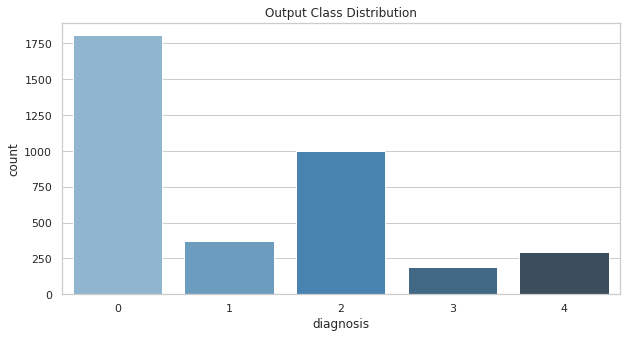

In [8]:
plot_classes(df_train)

**Plot Summary - As we can see, there is class imbalance in the output class distribution. We shall account for this while training the models using data augmentation / class balancing methods**

In [9]:
# Defining a global variable to be used as Image size..
IMG_SIZE = 224

In [10]:
'''This Function converts a color image to gray scale image'''

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img
  
    
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class)
'''

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

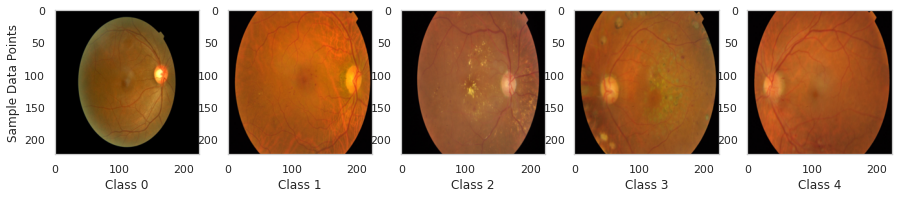

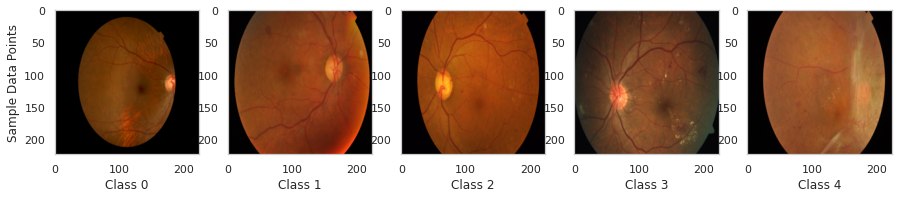

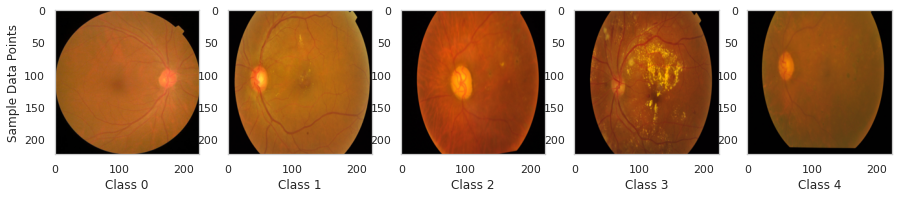

In [11]:
visualize_imgs(df_train,3,color_scale = None)

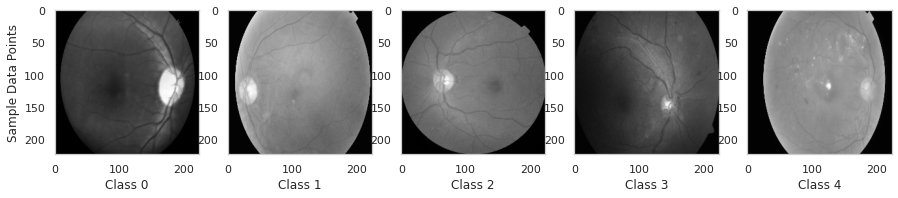

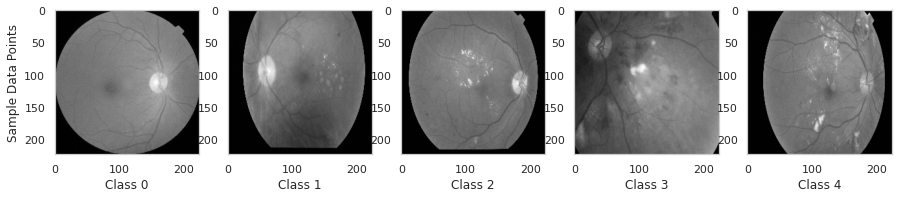

In [12]:
visualize_imgs(df_train,2,color_scale = 'gray')

**Plot summary - As we can see, as we move towards higher classes, we are able to comprehend larger number of abnormalities in the eye images. Also, the lightning and brightness conditions are not even across all images. We will try to handle this using image processing techniques. Also, Gray Scale Images are giving better visualization of the eye features as compared to RGB images**

In [13]:
# reference - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.-Further-improve-by-auto-cropping

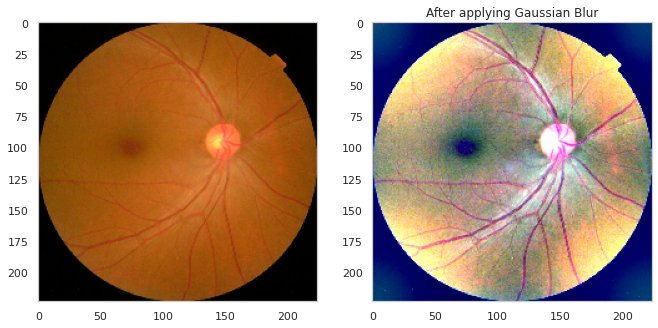

In [14]:
'''
This section of code applies gaussian blur on top of image
'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

**Plot summary - As we can see, after applying Gaussian Blur, We are able to bring out the features/image details much more clearer in the eye.**

In [15]:
'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
'''

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

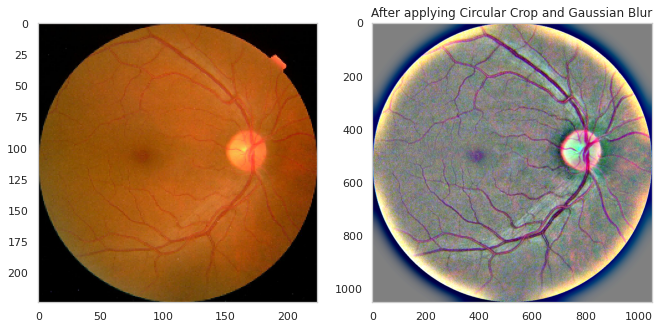

In [16]:
'''Perform Image Processing on a sample image'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

**Plot summary - As we can see above, now the image features and details are very much clearer than what the image was before, we are ready to use this image for modelling as the image details are much more clearer**

In [17]:
# ref - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

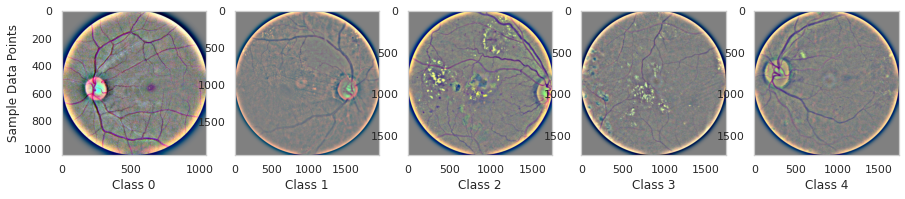

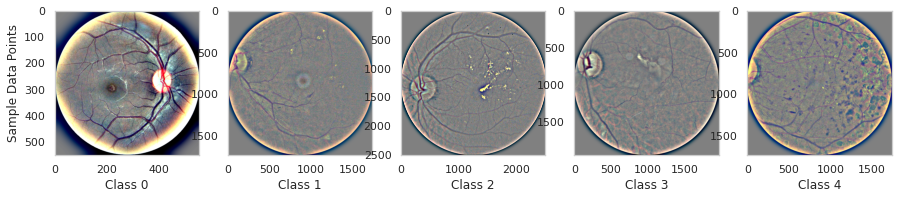

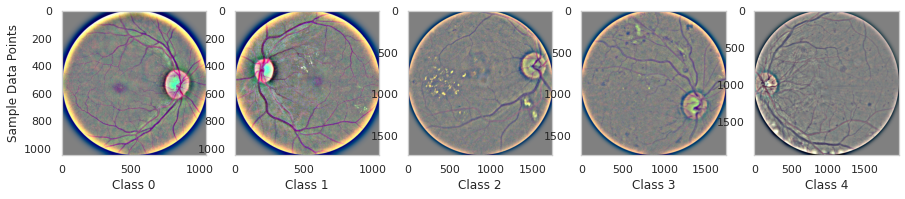

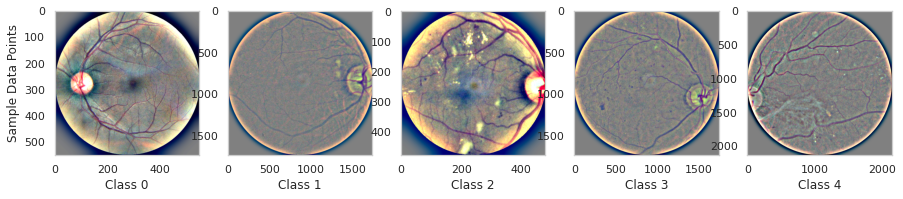

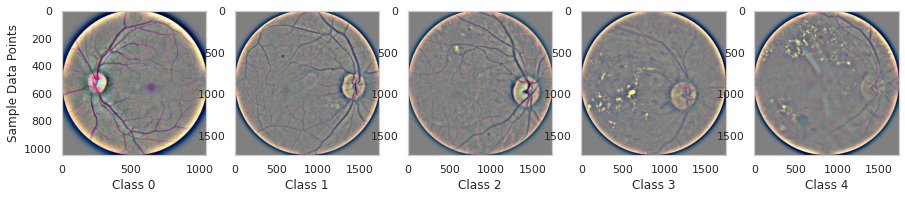

In [18]:
visualize_img_process(df_train,5,sigmaX = 30)

**Visualizations Summary - Clearly we understand the importance of performing image processing operations here. We have performed Gaussian Blur to bring out the image details and features much more clearly and explicitly.**

In [ ]:
'''
The code below applies TSNE on Gray Scale Images - The Image is flattened to 2D Gray Image to 1D and then applies TSNE
'''
# ref - https://www.kaggle.com/code1110/are-there-clusters-pca-tsne-vae


In [ ]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))

In [ ]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

In [ ]:
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

**Plot summary - As we can see, we are able to seperate Class '0' from other classes (1-4). Seperating between classes 1-4 looks challenging.**

In [19]:
# ref - https://www.youtube.com/watch?v=hxLU32zhze0
# ref - https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
# ref - https://keras.io/preprocessing/image/

'''This Function generates 'lim' number of Image Augmentations from a random Image in the directory'''

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()

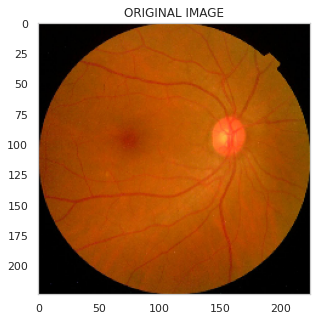

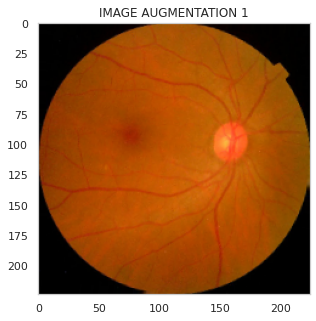

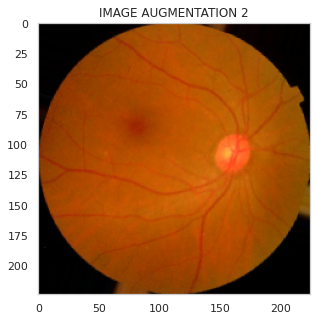

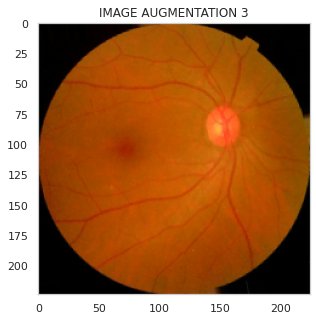

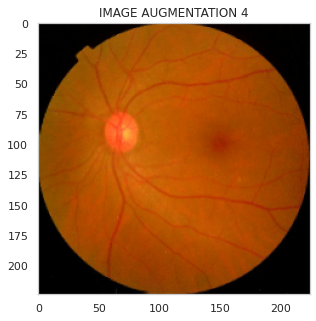

In [20]:
generate_augmentations(4)

**Plot Summary - As we can see above, Image Augmentations are extremely helpful for this datasets to make our Models more Robust and would also have a higher ability to generalize well**

In [21]:
# Model parameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
HEIGHT = 224
WIDTH = 224
N_CLASSES = df_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [22]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=360,
                                 brightness_range=[0.5, 1.5],
                                 zoom_range=[1, 1.2],
                                 zca_whitening=True,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='constant')
    # add shuffle = True for both train and validation
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="../input/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="../input/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                      directory = "../input/aptos2019-blindness-detection/test_images",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [23]:
train_generator,valid_generator,test_generator = img_generator(df_train,df_test)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [24]:
inception_model = InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=(HEIGHT,WIDTH,3)
)

87916544/87910968 [==============================] - 1s 0us/step


In [25]:
for i, layer in enumerate(inception_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [26]:
NUM_CLASSES =N_CLASSES

model = Sequential ()
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
#model.add(layers.Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [27]:
for layer in inception_model.layers:
    layer.trainable = False

In [28]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6

In [29]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size



In [30]:
history = model.fit (train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
91/91 [==============================] - 618s 7s/step - loss: 1.0328 - accuracy: 0.6224 - val_loss: 0.7678 - val_accuracy: 0.7273
Epoch 2/10
91/91 [==============================] - 418s 5s/step - loss: 0.7622 - accuracy: 0.7208 - val_loss: 0.7508 - val_accuracy: 0.7202
Epoch 3/10
91/91 [==============================] - 415s 5s/step - loss: 0.6939 - accuracy: 0.7388 - val_loss: 0.7030 - val_accuracy: 0.7457
Epoch 4/10
91/91 [==============================] - 418s 5s/step - loss: 0.7187 - accuracy: 0.7287 - val_loss: 0.7131 - val_accuracy: 0.7301
Epoch 5/10
91/91 [==============================] - 419s 5s/step - loss: 0.6915 - accuracy: 0.7423 - val_loss: 0.7165 - val_accuracy: 0.7429
Epoch 6/10
91/91 [==============================] - 412s 5s/step - loss: 0.6766 - accuracy: 0.7468 - val_loss: 0.7321 - val_accuracy: 0.7202
Epoch 7/10
91/91 [==============================] - 416s 5s/step - loss: 0.6632 - accuracy: 0.7503 - val_loss: 0.6943 - val_accuracy: 0.7287
Epoch 8/10
91

In [31]:
for layer in inception_model.layers[:133]:
    layer.trainable = False
for layer in inception_model.layers[133:]:
    layer.trainable = True


In [32]:
NUM_CLASSES =N_CLASSES

model2 = Sequential ()
model2.add(inception_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(1024, activation = 'relu'))
model2.add(Dense(512,activation = 'relu'))
model2.add(Dense(256,activation = 'relu'))
model2.add(Dense(128,activation = 'relu'))
#model.add(layers.Dropout(0.5))
model2.add(Dense(NUM_CLASSES, activation='softmax'))

In [33]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

In [35]:
from keras.callbacks import ModelCheckpoint
saved_model = './inception_model.h5'
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model2.fit (train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,callbacks=[checkpoint])

Epoch 1/40
91/91 [==============================] - 425s 5s/step - loss: 0.9806 - accuracy: 0.6327 - val_loss: 0.8928 - val_accuracy: 0.7244

Epoch 00001: val_accuracy improved from -inf to 0.72443, saving model to ./inception_model.h5
Epoch 2/40
91/91 [==============================] - 413s 5s/step - loss: 0.6356 - accuracy: 0.7569 - val_loss: 0.6306 - val_accuracy: 0.7713

Epoch 00002: val_accuracy improved from 0.72443 to 0.77131, saving model to ./inception_model.h5
Epoch 3/40
91/91 [==============================] - 412s 5s/step - loss: 0.5791 - accuracy: 0.7844 - val_loss: 0.6061 - val_accuracy: 0.7642

Epoch 00003: val_accuracy did not improve from 0.77131
Epoch 4/40
91/91 [==============================] - 412s 5s/step - loss: 0.5575 - accuracy: 0.7795 - val_loss: 0.5907 - val_accuracy: 0.7841

Epoch 00004: val_accuracy improved from 0.77131 to 0.78409, saving model to ./inception_model.h5
Epoch 5/40
91/91 [==============================] - 413s 5s/step - loss: 0.5174 - accurac

In [36]:
savedModel = load_model('./inception_model.h5')

In [37]:
loss,acc=savedModel.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_TEST,verbose = 1)
print("Validation Accuracy ",np.round(acc*100,2))

1928/1928 [==============================] - 90s 44ms/step - loss: 0.5769 - accuracy: 0.7883
Validation Accuracy  78.83


In [38]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
loss,acc = savedModel.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST,verbose = 1) # if error occurs use replace evaluate_generator with evaluate
print("Test accuracy",np.round(acc*100,2))

1928/1928 [==============================] - 117s 60ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy 0.0


In [39]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model2.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

1928/1928 [==============================] - 82s 42ms/step


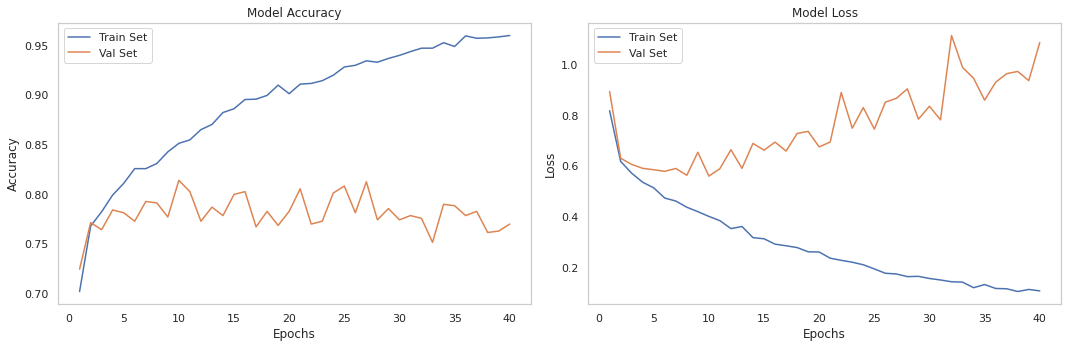

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model2.save('./inception_model.h5')

In [42]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title     A   = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_test['diagnosis'].astype(int)),test_labels,labels)

In [ ]:
print(classificaton_report(list(df_test['diagnosis'].astype(int)),test_labels,labels))

# Fine tune InceptionResnetv2

In [ ]:
from keras.applications import InceptionResNetV2

In [ ]:
base_model2 = InceptionResNetV2( weights = 'imagenet',include_top = False, input_shape = (WIDTH,HEIGHT,3))
base_model2.summary()

In [ ]:
for i, layer in enumerate(base_model2.layers):
    print(i, layer.name)

In [ ]:
NUM_CLASSES =N_CLASSES

model3 = Sequential ()
model3.add(base_model2)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(1024, activation = 'relu'))
model3.add(Dense(512,activation = 'relu'))
model3.add(Dense(256,activation = 'relu'))
model3.add(Dense(128,activation = 'relu'))
#model.add(layers.Dropout(0.5))
model3.add(Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
model3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

model3.summary()

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history = model3.fit (train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)